In [32]:
import importlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import challenge22

sns.set(font_scale=0.6)

<module 'challenge22' from '/home/justin/Documents/git/challenge22/challenge22.py'>

In [40]:
class Input:
    def __init__(self, log_file: str = 'right.txt'):
        importlib.reload(challenge22)
        self.frame = 0
        self.log_file = log_file
        self.cache = self.get_cache()

    def next_frame(self, frame):
        if frame is not None:
            self.frame = frame
        elif self.frame < len(self.cache):
            self.frame += 1
        else:
            self.frame = 1

    @property
    def max_frame(self):
        return len(self.cache)

    def my_matter(self, frame=None):
        self.next_frame(frame)
        return self.cache[self.frame]['my_matter']

    def op_matter(self, frame=None):
        self.next_frame(frame)
        return self.cache[self.frame]['op_matter']

    def input_array(self, frame=None):
        self.next_frame(frame)
        return self.cache[self.frame]['input_array']
    
    def board(self, frame=None):
        self.next_frame(frame)
        return self.cache[self.frame]['board']
    
    def all(self, frame=None):
        self.next_frame(frame)
        return (
            self.frame,
            self.cache[self.frame]['my_matter'],
            self.cache[self.frame]['op_matter'],
            self.cache[self.frame]['input_array'],
            self.cache[self.frame]['board'],
        )

    def get_cache(self):
        io = challenge22.InputOutput(self.log_file)
        col, row = io.get_input()

        cache = {}
        frame = 0

        while True:
            try:
                frame += 1
                my_matter, op_matter = io.get_input()
                input_array = np.array(io.get_input(row * col)).reshape(row, col, 7)
                cache[frame] = {
                    'my_matter': my_matter,
                    'op_matter': op_matter,
                    'input_array': input_array,
                    'board': challenge22.Board(input_array)
                }
            except EOFError:
                break
        return cache

4

In [37]:
input = Input()
frame, my_matter, op_matter, input_array, board = input.all()

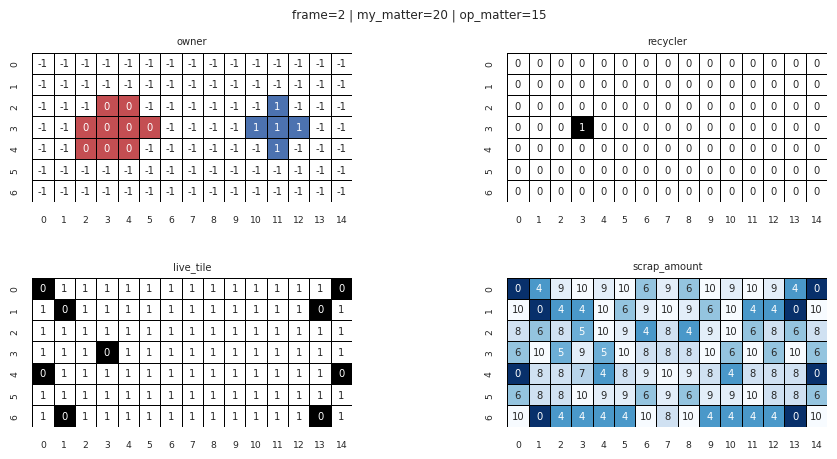

In [5]:
default_params = {'annot': True, 'fmt': "d", 'linecolor': 'black', 'linewidths': .5, 'square': True, 'cbar': False}

frame, my_matter, op_matter, input_array, board = input.all()

fig, ax = plt.subplots(2, 2, figsize=(10, 5))
plt.tight_layout(h_pad=5, pad=5)

plt.suptitle(f'{frame=} | {my_matter=} | {op_matter=}')

sns.heatmap(**default_params, ax=ax[0,0], data=board.owner, cmap=['white','r','b']).set_title('owner')
sns.heatmap(**default_params, ax=ax[1,0], data=board.live_tile, cmap=['black','white']).set_title('live_tile')
sns.heatmap(**default_params, ax=ax[0,1], data=board.recycler, cmap=['white', 'black']).set_title('recycler')
sns.heatmap(**default_params, ax=ax[1,1], data=board.scrap_amount, cmap='Blues_r').set_title('scrap_amount')
plt.show()

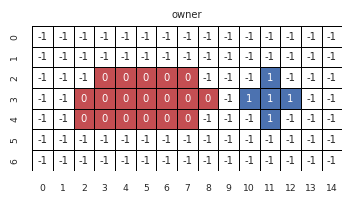

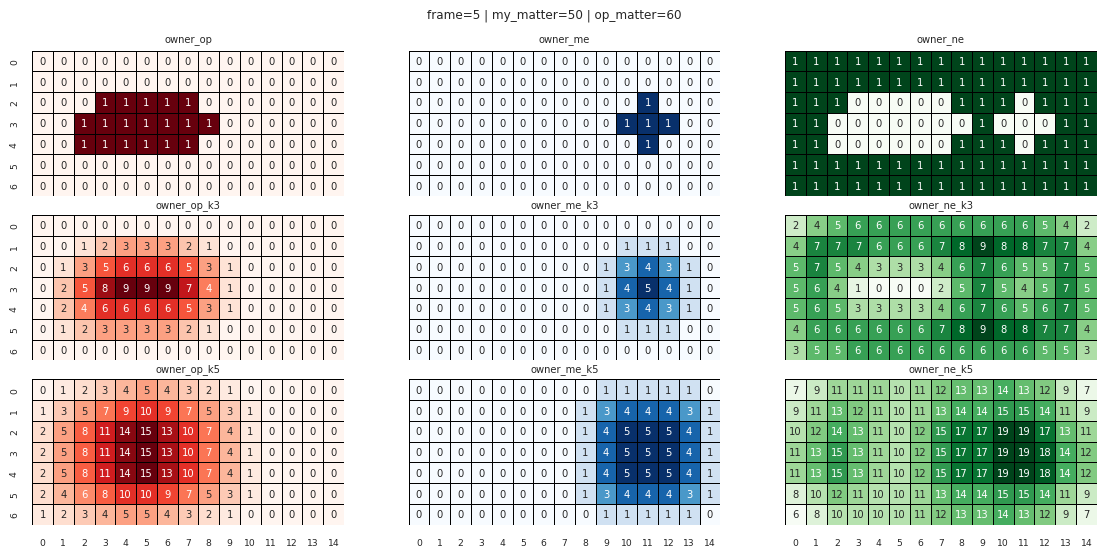

In [8]:
default_params = {'annot': True, 'fmt': "d", 'linecolor': 'black', 'linewidths': .5, 'square': True, 'cbar': False}

frame, my_matter, op_matter, input_array, board = input.all(5)

plt.figure(figsize=(4, 3))
sns.heatmap(**default_params, data=board.owner, cmap=['white','r','b']).set_title('owner')
plt.show()

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 6), sharex=True, sharey=True)
plt.tight_layout(h_pad=1, pad=5)

plt.suptitle(f'{frame=} | {my_matter=} | {op_matter=}')

sns.heatmap(**default_params, ax=ax[0, 0], data=board.owner == 0, cmap='Reds').set_title('owner_op')
sns.heatmap(**default_params, ax=ax[0, 1], data=board.owner == 1, cmap='Blues').set_title('owner_me')
sns.heatmap(**default_params, ax=ax[0, 2], data=board.owner == -1, cmap='Greens').set_title('owner_ne')
sns.heatmap(**default_params, ax=ax[1, 0], data=board.owner_op_k3, cmap='Reds').set_title('owner_op_k3')
sns.heatmap(**default_params, ax=ax[1, 1], data=board.owner_me_k3, cmap='Blues').set_title('owner_me_k3')
sns.heatmap(**default_params, ax=ax[1, 2], data=board.owner_ne_k3, cmap='Greens').set_title('owner_ne_k3')
sns.heatmap(**default_params, ax=ax[2, 0], data=board.owner_op_k5, cmap='Reds').set_title('owner_op_k5')
sns.heatmap(**default_params, ax=ax[2, 1], data=board.owner_me_k5, cmap='Blues').set_title('owner_me_k5')
sns.heatmap(**default_params, ax=ax[2, 2], data=board.owner_ne_k5, cmap='Greens').set_title('owner_ne_k5')
plt.show()

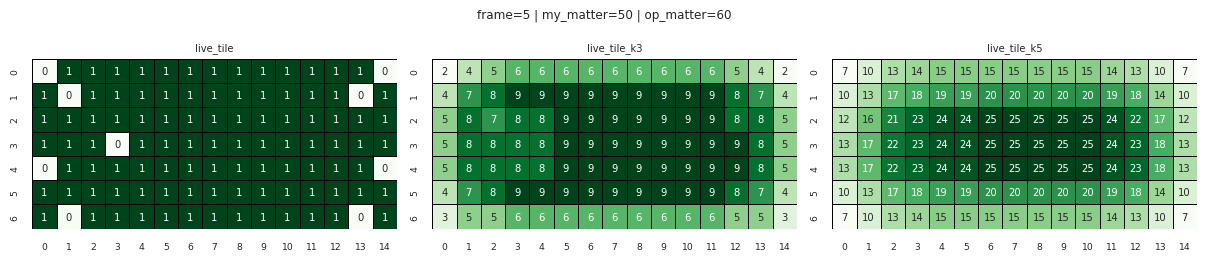

In [9]:
default_params = {'annot': True, 'fmt': "d", 'linecolor': 'black', 'linewidths': .5, 'square': True, 'cbar': False}

frame, my_matter, op_matter, input_array, board = input.all(5)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
plt.tight_layout(pad=0)

plt.suptitle(f'{frame=} | {my_matter=} | {op_matter=}')

sns.heatmap(**default_params, ax=ax[0], data=board.live_tile, cmap='Greens').set_title('live_tile')
sns.heatmap(**default_params, ax=ax[1], data=board.live_tile_k3, cmap='Greens').set_title('live_tile_k3')
sns.heatmap(**default_params, ax=ax[2], data=board.live_tile_k5, cmap='Greens').set_title('live_tile_k5')
plt.show()

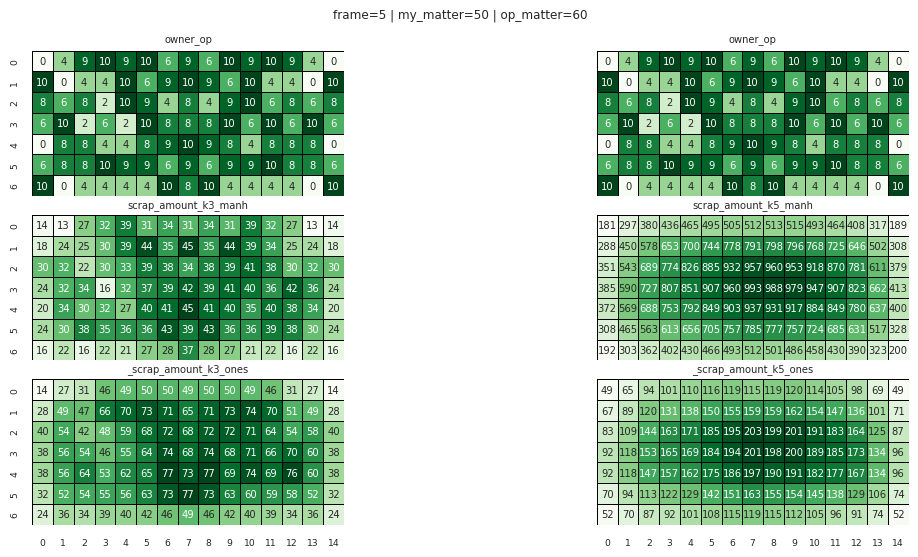

In [4]:
default_params = {'annot': True, 'fmt': "d", 'linecolor': 'black', 'linewidths': .5, 'square': True, 'cbar': False}

frame, my_matter, op_matter, input_array, board = input.all(5)

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 6), sharex=True, sharey=True)
plt.tight_layout(h_pad=1, pad=5)

plt.suptitle(f'{frame=} | {my_matter=} | {op_matter=}')

sns.heatmap(**default_params, ax=ax[0, 0], data=board.scrap_amount, cmap='Greens').set_title('owner_op')
sns.heatmap(**default_params, ax=ax[0, 1], data=board.scrap_amount, cmap='Greens').set_title('owner_op')

sns.heatmap(**default_params, ax=ax[1, 0], data=board.scrap_amount_k3_manh, cmap='Greens').set_title('scrap_amount_k3_manh')
sns.heatmap(**default_params, ax=ax[1, 1], data=board.scrap_amount_k5_manh, cmap='Greens').set_title('scrap_amount_k5_manh')

sns.heatmap(**default_params, ax=ax[2, 0], data=board._scrap_amount_k3_ones, cmap='Greens').set_title('_scrap_amount_k3_ones')
sns.heatmap(**default_params, ax=ax[2, 1], data=board._scrap_amount_k5_ones, cmap='Greens').set_title('_scrap_amount_k5_ones')
plt.show()

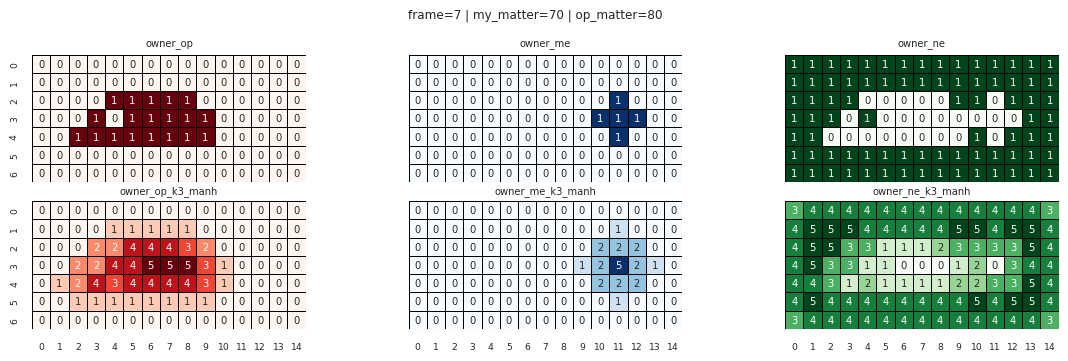

In [50]:
default_params = {'annot': True, 'fmt': "d", 'linecolor': 'black', 'linewidths': .5, 'square': True, 'cbar': False}

input = Input(log_file='right.txt')
last_frame = input.max_frame

frame, my_matter, op_matter, input_array, board = input.all(7)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 4), sharex=True, sharey=True)
plt.tight_layout(h_pad=1, pad=5)

plt.suptitle(f'{frame=} | {my_matter=} | {op_matter=}')

sns.heatmap(**default_params, ax=ax[0, 0], data=board.owner_op, cmap='Reds').set_title('owner_op')
sns.heatmap(**default_params, ax=ax[1, 0], data=board.owner_op_k3_manh, cmap='Reds').set_title('owner_op_k3_manh')

sns.heatmap(**default_params, ax=ax[0, 1], data=board.owner_me, cmap='Blues').set_title('owner_me')
sns.heatmap(**default_params, ax=ax[1, 1], data=board.owner_me_k3_manh, cmap='Blues').set_title('owner_me_k3_manh')

sns.heatmap(**default_params, ax=ax[0, 2], data=board.owner_ne, cmap='Greens').set_title('owner_ne')
sns.heatmap(**default_params, ax=ax[1, 2], data=board.owner_ne_k3_manh, cmap='Greens').set_title('owner_ne_k3_manh')
plt.show()

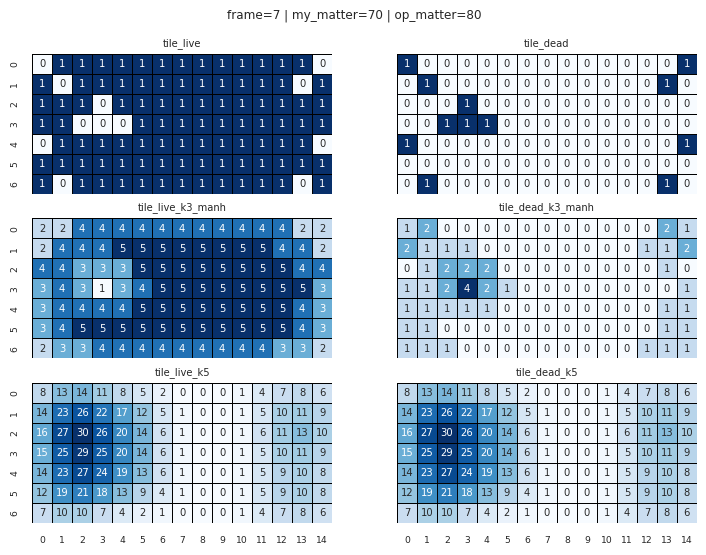

In [53]:
default_params = {'annot': True, 'fmt': "d", 'linecolor': 'black', 'linewidths': .5, 'square': True, 'cbar': False}

input = Input(log_file='right.txt')
last_frame = input.max_frame

frame, my_matter, op_matter, input_array, board = input.all(7)

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8, 6), sharex=True, sharey=True)
plt.tight_layout(h_pad=1, pad=5)

plt.suptitle(f'{frame=} | {my_matter=} | {op_matter=}')

sns.heatmap(**default_params, ax=ax[0, 0], data=board.tile_live, cmap='Blues').set_title('tile_live')
sns.heatmap(**default_params, ax=ax[1, 0], data=board.tile_live_k3_manh, cmap='Blues').set_title('tile_live_k3_manh')
sns.heatmap(**default_params, ax=ax[2, 0], data=board.tile_live_k5, cmap='Blues').set_title('tile_live_k5')

sns.heatmap(**default_params, ax=ax[0, 1], data=board.tile_dead, cmap='Blues').set_title('tile_dead')
sns.heatmap(**default_params, ax=ax[1, 1], data=board.tile_dead_k3_manh, cmap='Blues').set_title('tile_dead_k3_manh')
sns.heatmap(**default_params, ax=ax[2, 1], data=board.tile_dead_k5, cmap='Blues').set_title('tile_dead_k5')
plt.show()

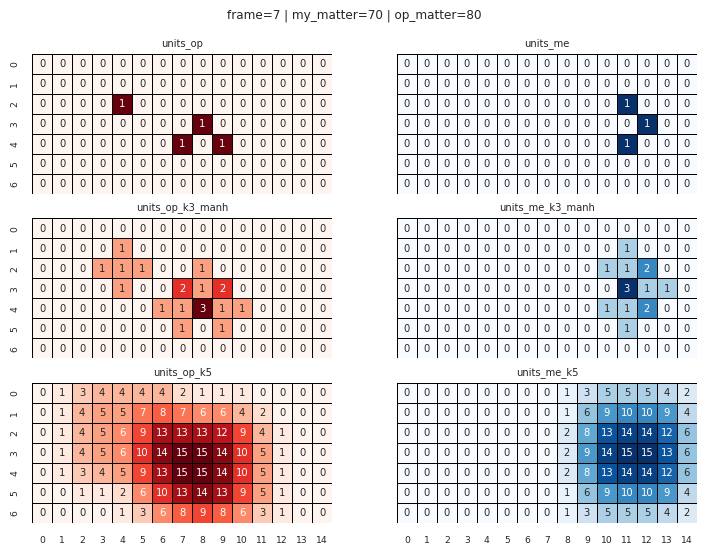

In [56]:
default_params = {'annot': True, 'fmt': "d", 'linecolor': 'black', 'linewidths': .5, 'square': True, 'cbar': False}

input = Input(log_file='right.txt')
last_frame = input.max_frame

frame, my_matter, op_matter, input_array, board = input.all(7)

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8, 6), sharex=True, sharey=True)
plt.tight_layout(h_pad=1, pad=5)

plt.suptitle(f'{frame=} | {my_matter=} | {op_matter=}')

sns.heatmap(**default_params, ax=ax[0, 0], data=board.units_op, cmap='Reds').set_title('units_op')
sns.heatmap(**default_params, ax=ax[1, 0], data=board.units_op_k3_manh, cmap='Reds').set_title('units_op_k3_manh')
sns.heatmap(**default_params, ax=ax[2, 0], data=board.units_op_k5, cmap='Reds').set_title('units_op_k5')

sns.heatmap(**default_params, ax=ax[0, 1], data=board.units_me, cmap='Blues').set_title('units_me')
sns.heatmap(**default_params, ax=ax[1, 1], data=board.units_me_k3_manh, cmap='Blues').set_title('units_me_k3_manh')
sns.heatmap(**default_params, ax=ax[2, 1], data=board.units_me_k5, cmap='Blues').set_title('units_me_k5')

plt.show()

# Features to keep

### Scrap amount

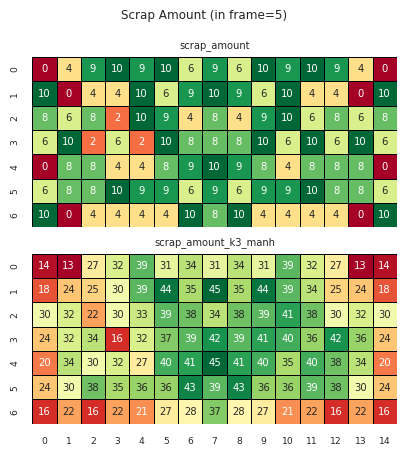

In [100]:
feature = "Scrap Amount"

default_params = {'annot': True, 'fmt': "d", 'linecolor': 'black', 'linewidths': .5, 'square': True, 'cbar': False}

frame, my_matter, op_matter, input_array, board = input.all(5)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5, 5), sharex=True, sharey=True)
plt.tight_layout(h_pad=1, pad=5)

sns.heatmap(**default_params, ax=ax[0], data=board.scrap_amount, cmap='RdYlGn').set_title('scrap_amount')
sns.heatmap(**default_params, ax=ax[1], data=board.scrap_amount_k3_manh, cmap='RdYlGn').set_title('scrap_amount_k3_manh')

plt.suptitle(f'{feature} (in {frame=})')
plt.show()

### Owner

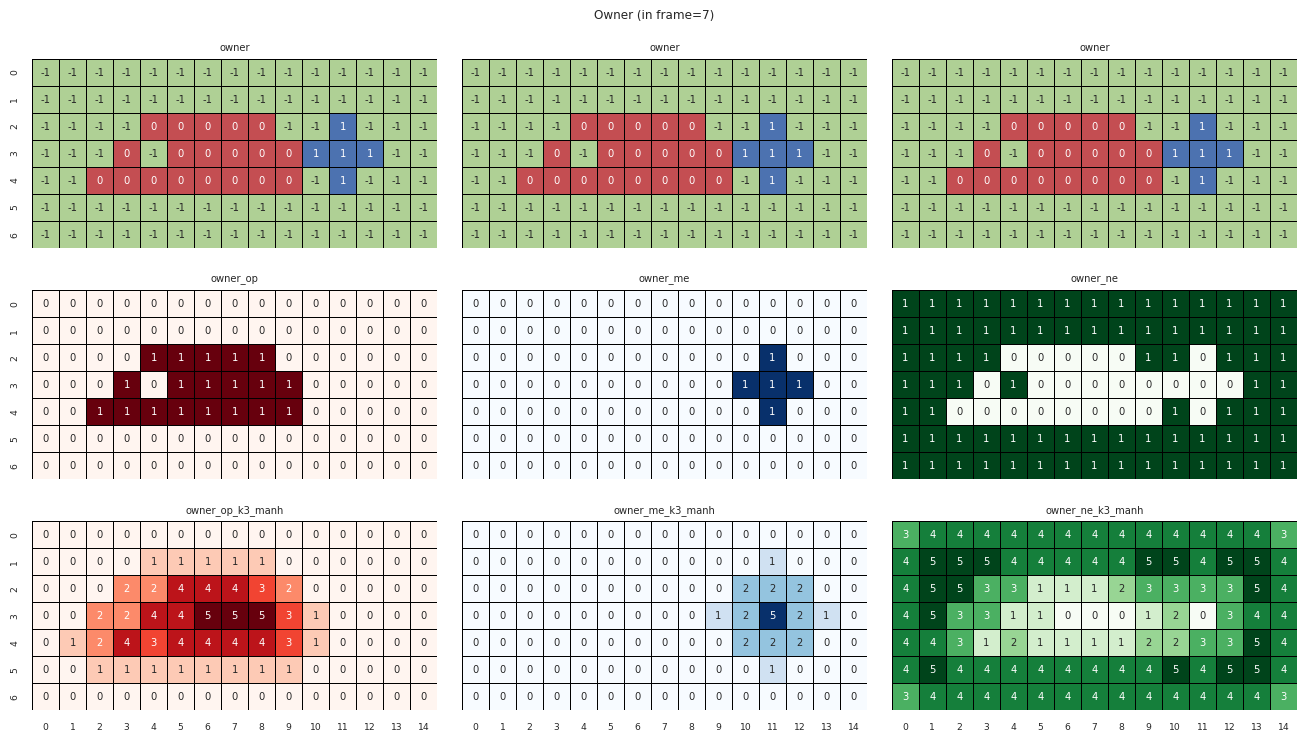

In [101]:
feature = "Owner"

default_params = {'annot': True, 'fmt': "d", 'linecolor': 'black', 'linewidths': .5, 'square': True, 'cbar': False}

input = Input(log_file='right.txt')
last_frame = input.max_frame

frame, my_matter, op_matter, input_array, board = input.all(7)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14, 8), sharex=True, sharey=True)
plt.tight_layout(h_pad=1, w_pad=1, pad=5)

sns.heatmap(**default_params, ax=ax[0, 0], data=board.owner, cmap=['#afd095','r','b']).set_title('owner')
sns.heatmap(**default_params, ax=ax[1, 0], data=board.owner_op, cmap='Reds').set_title('owner_op')
sns.heatmap(**default_params, ax=ax[2, 0], data=board.owner_op_k3_manh, cmap='Reds').set_title('owner_op_k3_manh')

sns.heatmap(**default_params, ax=ax[0, 1], data=board.owner, cmap=['#afd095','r','b']).set_title('owner')
sns.heatmap(**default_params, ax=ax[1, 1], data=board.owner_me, cmap='Blues').set_title('owner_me')
sns.heatmap(**default_params, ax=ax[2, 1], data=board.owner_me_k3_manh, cmap='Blues').set_title('owner_me_k3_manh')

sns.heatmap(**default_params, ax=ax[0, 2], data=board.owner, cmap=['#afd095','r','b']).set_title('owner')
sns.heatmap(**default_params, ax=ax[1, 2], data=board.owner_ne, cmap='Greens').set_title('owner_ne')
sns.heatmap(**default_params, ax=ax[2, 2], data=board.owner_ne_k3_manh, cmap='Greens').set_title('owner_ne_k3_manh')

plt.suptitle(f'{feature} (in {frame=})')
plt.show()

### 

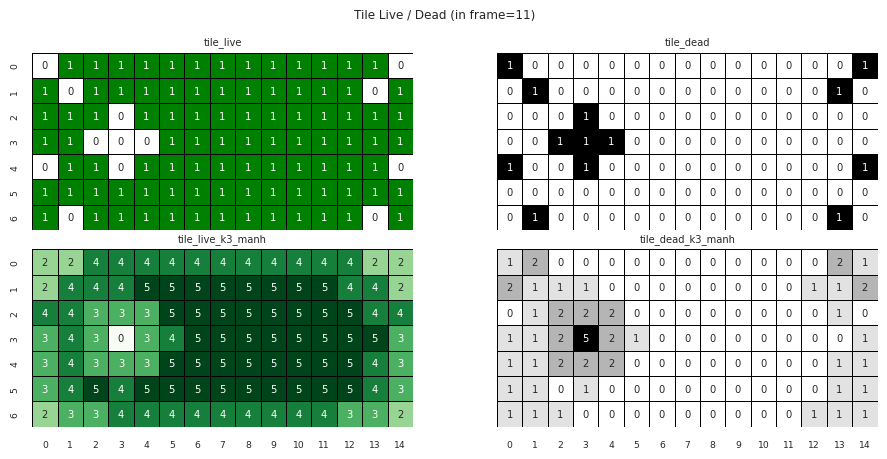

In [123]:
feature = "Tile Live / Dead"

default_params = {'annot': True, 'fmt': "d", 'linecolor': 'black', 'linewidths': .5, 'square': True, 'cbar': False}

input = Input(log_file='right.txt')
last_frame = input.max_frame

frame, my_matter, op_matter, input_array, board = input.all(last_frame)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 5), sharex=True, sharey=True)
plt.tight_layout(h_pad=1, pad=5)

sns.heatmap(**default_params, ax=ax[0, 0], data=board.tile_live, cmap=['White', 'Green']).set_title('tile_live')
sns.heatmap(**default_params, ax=ax[1, 0], data=board.tile_live_k3_manh, cmap='Greens').set_title('tile_live_k3_manh')

sns.heatmap(**default_params, ax=ax[0, 1], data=board.tile_dead, cmap=['White', 'Black']).set_title('tile_dead')
sns.heatmap(**default_params, ax=ax[1, 1], data=board.tile_dead_k3_manh, cmap='Greys').set_title('tile_dead_k3_manh')

plt.suptitle(f'{feature} (in {frame=})')
plt.show()